# Project 2 - ASL Recognition using Canny Edge, Histogram of Oriented Gradients and KNN

## Step 0: Install dependencies and libraries

In [ ]:
%pip install --upgrade opencv-python tqdm scikit-image pandas \
    numpy matplotlib keras tensorflow scikit-learn seaborn

In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage import exposure, data
import matplotlib.pyplot as plt
import os.path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA 

/Users/thomaskahessay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Step 1: Upload Dataset

In [3]:
TRAIN_DIR = "asl_alphabet_train/asl_alphabet_train/"
TEST_DIR = "asl_alphabet_test/asl_alphabet_test/"

In [4]:
def load_data(directory, num_of_images=3000):
    images = []
    labels = []

    # Iterate through each image in each subfolder
    for folder in os.listdir(directory):
        count = 0
        for image in os.listdir(directory + "/" + folder):
            count += 1
            temp_img = cv.imread(directory + '/' + folder + '/' + image)
            
            if temp_img is None:
                continue

            images.append(temp_img)
            labels.append(folder)
            if count == num_of_images:
                break

    # Convert to a numpy array
    images = np.array(images)
    
    return images, labels

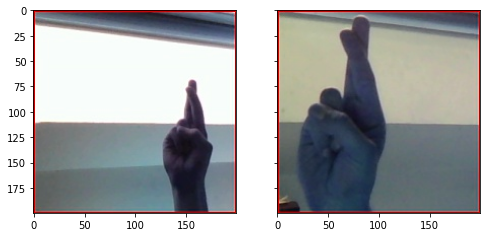

In [5]:
X_train, y_train = load_data(TRAIN_DIR)
X_test, y_test = load_data(TEST_DIR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.imshow(X_train[0], cmap=plt.cm.gray)
ax2.imshow(X_test[0], cmap=plt.cm.gray)
plt.show()

## Step 2: Image Preprocessing

In [6]:
processed_train_images = []
processed_test_images = []

for image in X_train:
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)
    processed_train_images.append(blurred)

for image in X_test:
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)
    processed_test_images.append(blurred)

## Step 3: Otsu Segmentation

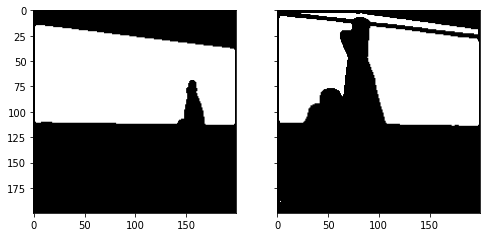

In [8]:
segmented_train_images = []
segmented_test_images = []

for image in processed_train_images:
    otsu_threshold, image_result = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    segmented_train_images.append(image_result)

for image in processed_test_images:
    otsu_threshold, image_result = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    segmented_test_images.append(image_result)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
otsu_train_image_rescaled = exposure.rescale_intensity(segmented_train_images[0], in_range=(0, 10))
otsu_test_image_rescaled = exposure.rescale_intensity(segmented_test_images[0], in_range=(0, 10))
ax1.imshow(otsu_train_image_rescaled, cmap=plt.cm.gray)
ax2.imshow(otsu_test_image_rescaled, cmap=plt.cm.gray)
plt.show()

## Step 4: Feature Extraction (Canny Edge & HOG)

### Canny Edge Detection

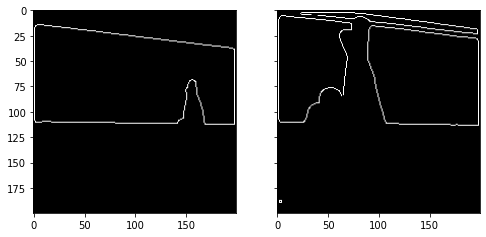

In [9]:
def canny_edge(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv.Canny(image, lower, upper)
    return edged

canny_edge_train_images = []
canny_edge_test_images = []

for image in segmented_train_images: 
    auto = canny_edge(image)
    canny_edge_train_images.append(auto)

for image in segmented_test_images:
    auto = canny_edge(image)
    canny_edge_test_images.append(auto)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

auto_train_image_rescaled = exposure.rescale_intensity(canny_edge_train_images[0], in_range=(0, 10))
auto_test_image_rescaled = exposure.rescale_intensity(canny_edge_test_images[0], in_range=(0, 10))

ax1.imshow(auto_train_image_rescaled, cmap=plt.cm.gray)
ax2.imshow(auto_test_image_rescaled, cmap=plt.cm.gray)
plt.show()

### Histogram of Oriented Gradients

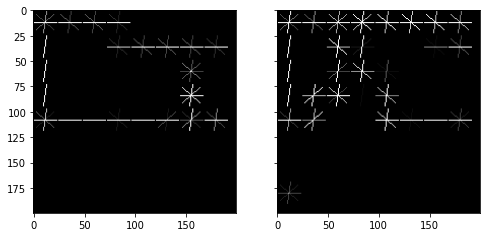

In [10]:
hog_train_images = []
hog_train_features = []
hog_test_images = []
hog_test_features = []

for image in canny_edge_train_images:
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(24, 24), cells_per_block=(2, 2), visualize=True, block_norm='L2', feature_vector=True)
    hog_train_images.append(hog_image)
    hog_train_features.append(fd)

for image in canny_edge_test_images:
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(24, 24), cells_per_block=(2, 2), visualize=True, block_norm='L2', feature_vector=True)
    hog_test_images.append(hog_image)
    hog_test_features.append(fd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
hog_train_image_rescaled = exposure.rescale_intensity(hog_train_images[0], in_range=(0, 10))
hog_test_image_rescaled = exposure.rescale_intensity(hog_test_images[0], in_range=(0, 10))
ax1.imshow(hog_train_image_rescaled, cmap=plt.cm.gray)
ax2.imshow(hog_test_image_rescaled, cmap=plt.cm.gray)
plt.show()

Renaming the variables for ease of use.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(hog_train_features, y_train, random_state=0, test_size=0.2)
X_test = hog_test_features

## Step 5: Classification (KNN)

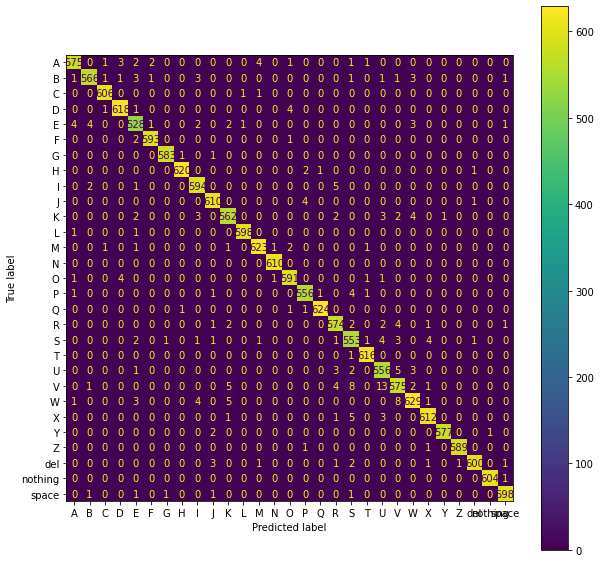

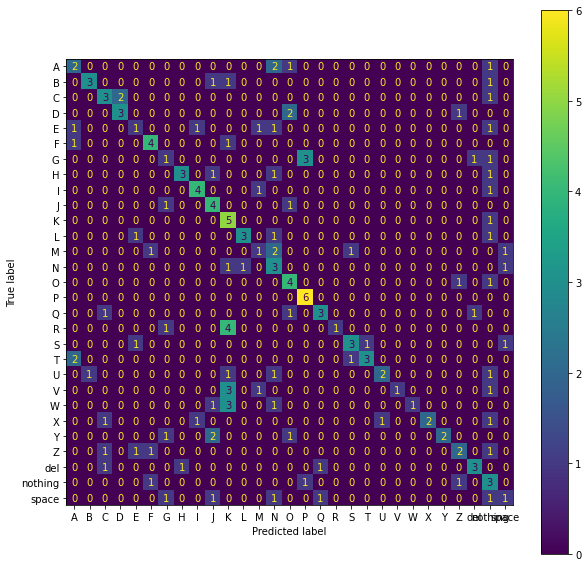

In [12]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

valid_predictions = clf.predict(X_valid)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predictions, ax=ax)

test_predictions = clf.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions, ax=ax)

In [13]:
print("Validation Score:", accuracy_score(y_valid, valid_predictions))
print("Test Score:", accuracy_score(y_test, test_predictions))

Validation Score: 0.9850574712643678
Test Score: 0.4425287356321839


In [14]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           A       0.33      0.33      0.33         6
           B       0.75      0.50      0.60         6
           C       0.43      0.50      0.46         6
           D       0.60      0.50      0.55         6
           E       0.25      0.17      0.20         6
           F       0.57      0.67      0.62         6
           G       0.20      0.17      0.18         6
           H       0.75      0.50      0.60         6
           I       0.67      0.67      0.67         6
           J       0.40      0.67      0.50         6
           K       0.26      0.83      0.40         6
           L       0.75      0.50      0.60         6
           M       0.25      0.17      0.20         6
           N       0.23      0.50      0.32         6
           O       0.40      0.67      0.50         6
           P       0.60      1.00      0.75         6
           Q       0.60      0.50      0.55         6
           R       1.00    

In [15]:
print(classification_report(y_valid, valid_predictions))

              precision    recall  f1-score   support

           A       0.98      0.97      0.98       590
           B       0.99      0.97      0.98       583
           C       0.99      1.00      1.00       608
           D       0.99      0.99      0.99       624
           E       0.96      0.97      0.97       546
           F       0.99      0.99      0.99       596
           G       1.00      1.00      1.00       585
           H       1.00      0.99      1.00       624
           I       0.98      0.99      0.98       602
           J       0.98      0.99      0.99       615
           K       0.97      0.97      0.97       579
           L       1.00      1.00      1.00       600
           M       0.99      0.99      0.99       630
           N       1.00      1.00      1.00       610
           O       0.98      0.99      0.99       599
           P       0.99      0.99      0.99       564
           Q       1.00      1.00      1.00       627
           R       0.97    

## Step 6: Modifications PCA 

In [45]:
X_pca_train = []
X_pca_valid = []
X_pca_test = []

n_values = [100,200,300,400,500]

for n in n_values: 
    pca = PCA(n_components=n).fit(X_train)
    X_pca_train.append(pca.transform(X_train))
    X_pca_valid.append(pca.transform(X_valid))
    X_pca_test.append(pca.transform(X_test))

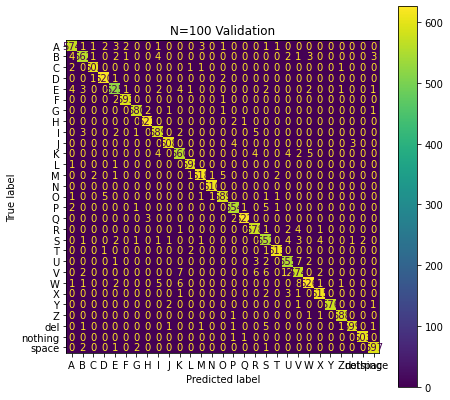

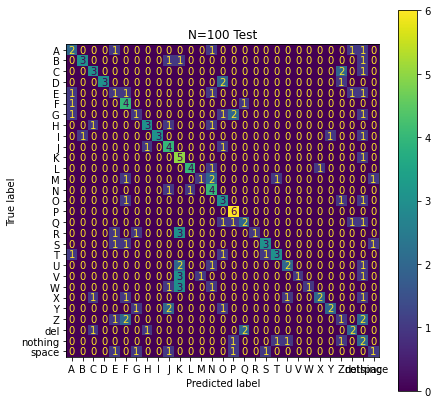

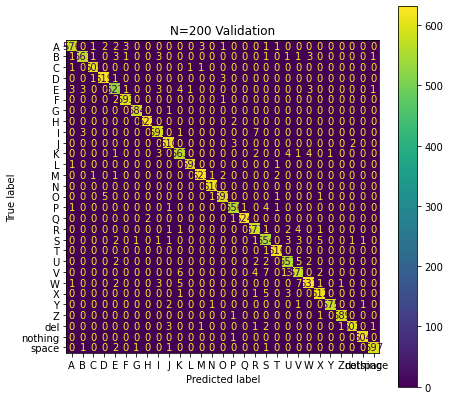

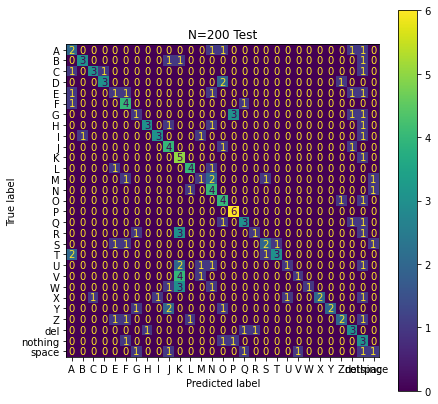

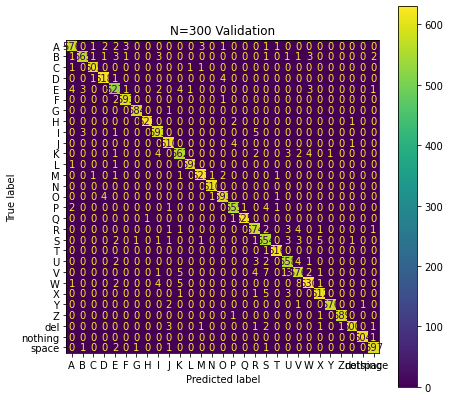

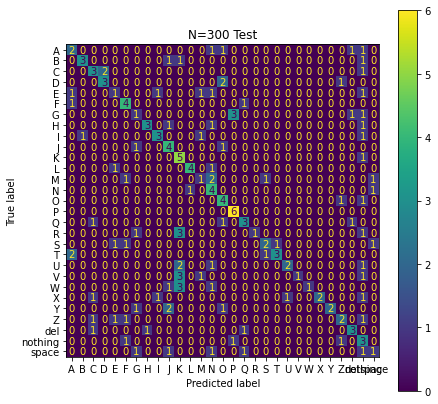

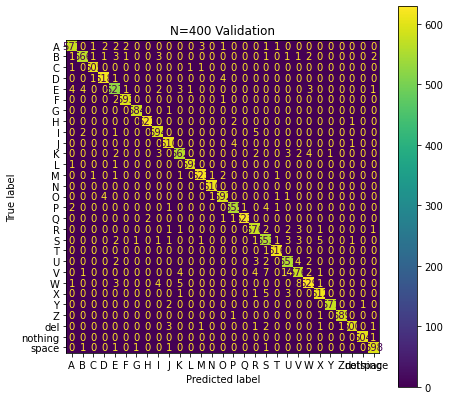

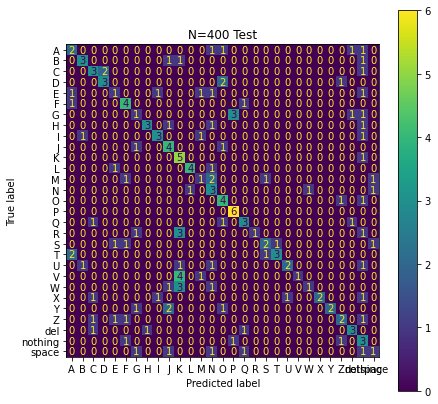

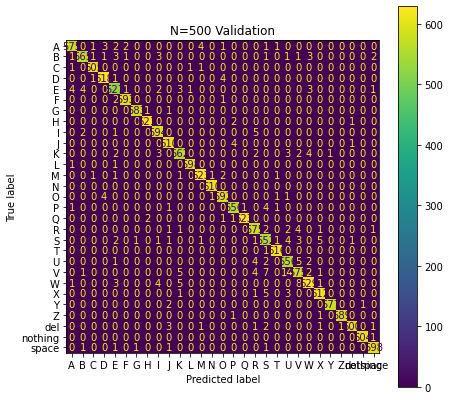

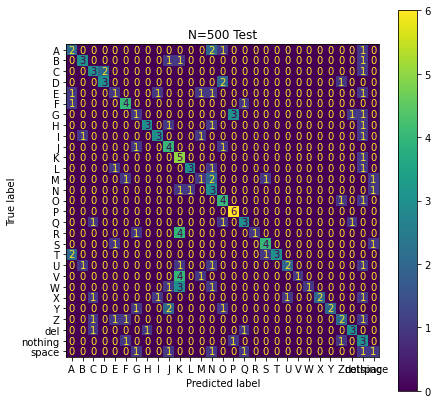

In [47]:
X_pca_valid_pred = []
X_pca_test_pred = []

for n in range(0, len(n_values)):
    nVal = n * 100 + 100
    nVal = str(nVal)

    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_pca_train[n], y_train)

    valid_predictions = clf.predict(X_pca_valid[n])
    X_pca_valid_pred.append(valid_predictions)
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.title('N=' + nVal + " Validation")
    ConfusionMatrixDisplay.from_predictions(y_valid, valid_predictions, ax=ax)

    test_predictions = clf.predict(X_pca_test[n])
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.title('N=' + nVal + " Test")
    X_pca_test_pred.append(test_predictions)
    ConfusionMatrixDisplay.from_predictions(y_test, test_predictions, ax=ax)

In [48]:
for n in range(0,len(n_values)):
    nVal = n * 100 + 100
    nVal = str(nVal)
    print("Validation Score for n=" + nVal + ":", accuracy_score(y_valid, X_pca_valid_pred[n]))
    print("Test Score for n=" + nVal + ":", accuracy_score(y_test, X_pca_test_pred[n]))

Validation Score for n=100: 0.9828735632183908
Test Score for n=100: 0.41954022988505746
Validation Score for n=200: 0.9855747126436781
Test Score for n=200: 0.4367816091954023
Validation Score for n=300: 0.9852873563218391
Test Score for n=300: 0.4425287356321839
Validation Score for n=400: 0.9853448275862069
Test Score for n=400: 0.4367816091954023
Validation Score for n=500: 0.9849425287356322
Test Score for n=500: 0.4425287356321839
